# Wind Power in Germany

---

**Disclaimer** :

The code below was created to complete of Dicoding course

## Data Set Information:

Wind power in Germany is leading the way in the field of renewable electricity generation. The installed capacity of all wind turbine generators (WTG’s) in the country amounted of more than 83,000 megawatts (MW) at the end of 2020.
![](https://en.wind-turbine-models.com/getfoto-QV4Qtp6di9P-turbine-nordex_n-50.jpg)
Wind turbines are the most important form of renewable energy exploitation, generating electricity both on land (onshore) and in the open sea (offshore). Very simply put, they work as wind mills combined with a dynamo: the wind makes the rotor turn and this movement is transformed into electrical energy by a generator.
The first wind turbines were already used for electricity generation in the early 20th century. Nevertheless, the worldwide interest in electricity generation by means of wind turbines only began to increase significantly after the oil crises of the 1970s. The development of the large renewable installations that are now common, began in the 1990s and has shown a strongly rising trend that continues to this day. This is due to requirements coming into force within the German Renewable Energy Sources Act (EEG) in the year 2000.

Unlike conventional power plants or renewable biomass installations, the electricity generation from wind energy fluctuates and strongly depending on the weather conditions. Unfortunately, the generational capacity from wind turbines rarely matches the electricity demand at the time. Depending on the wind speed, the volume of electricity generated by wind turbines varies and due to requiring large open spaces for efficient generation, turbines are often found in sparsely populated areas with a correspondingly low electricity demand.

Source dataset: [Wind Power in Germany](https://www.kaggle.com/datasets/l3llff/wind-power)

#### Import Dataset

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = 'lanaahm'
os.environ['KAGGLE_KEY'] = 'c5dac849baf021db5db739062fdf3105'

In [2]:
!kaggle datasets download -d l3llff/wind-power

  0% 0.00/2.13M [00:00<?, ?B/s]
100% 2.13M/2.13M [00:00<00:00, 170MB/s]


In [3]:
!unzip /content/wind-power.zip

Archive:  /content/wind-power.zip
  inflating: data.csv                


#### Import Library

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense, LSTM
from sklearn import preprocessing
from keras.callbacks import EarlyStopping

#### Exploring Data

##### Convert Dataset into pandas

In [5]:
df = pd.read_csv('/content/data.csv', index_col=['dt'], parse_dates=['dt'])
df.head()

,MW
dt,
2011-01-01 00:00:00,3416.0
2011-01-01 00:15:00,4755.0
2011-01-01 00:30:00,4939.0
2011-01-01 00:45:00,4939.0
2011-01-01 01:00:00,4998.0


##### Check Missing Value

In [6]:
df.isnull().sum()


MW    0
dtype: int64

##### Resample data
The Wind Power dataset in Germany is data with a time span of 15 minutes so I had to convert the data to a time span of 4 hours. because the weather usually changes within 4 hours so it can help machine learning in finding data patterns

In [7]:
df = df.resample('4H').mean().reset_index()

##### Data Visualization

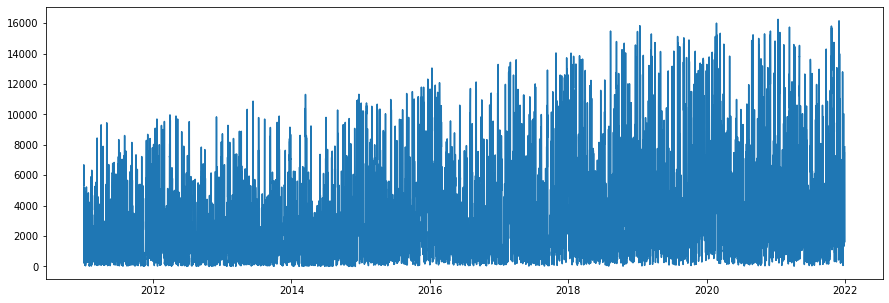

In [8]:
dates = df['dt'].values
mw  = df['MW'].values
 
plt.figure(figsize=(15,5))
plt.plot(dates, mw)

#### Requirements
Find minimum data and maximum data



In [9]:
minValue = df['MW'].min()
maxValue = df['MW'].max()

print(f'Min value dataset : {minValue}')
print(f'Max value dataset : {maxValue}')

Min value dataset : 0.25
Max value dataset : 16256.761875


MAE of the model < 10% data scale

In [10]:
maeRequirement = (maxValue - minValue) * 10/100
maeRequirement

1625.6511874999999

#### Data Preparation


In [56]:
split_time = int(len(df) * 0.8)

train = df.MW.values[:split_time]
test  = df.MW.values[split_time:]

window_size = 64
batch_size = 256
shuffle_buffer_size = 1000

##### Convert data to timeseries dataset

In [57]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

train_set = windowed_dataset(train, window_size, batch_size, shuffle_buffer_size)
test_set = windowed_dataset(test, window_size, batch_size, shuffle_buffer_size)

#### Build Model

In [63]:
def plot(val_train, val_test, title):
  plt.plot(val_train)
  plt.plot(val_test)
  plt.title(title)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.show()

In [81]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(8, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [120]:
#Custom callback
class myCallback(tf.keras.callbacks.Callback):
  def __init__(self, patience=0):
    super(myCallback, self).__init__()
    self.patience = patience
    self.best_weights = None
  def on_train_begin(self, logs=None):
    # The number of epoch it has waited when loss is no longer minimum.
    self.wait = 0
    # The epoch the training stops at.
    self.stopped_epoch = 0
    # Initialize the best as infinity.
    self.best_loss = np.Inf
    self.best_v_loss = np.Inf
  def on_epoch_end(self, epoch, logs=None):
    loss = 0 if logs.get('mae') is None else logs.get('mae')
    v_loss = 0 if logs.get('val_mae') is None else logs.get('val_mae')
    if np.less(loss, self.best_loss) and np.less(v_loss, self.best_v_loss):
      self.best_loss = loss
      self.best_v_loss = v_loss
      self.wait = 0
      self.best_weights = self.model.get_weights()
    else:
      self.wait += 1
      if self.wait >= self.patience \
      and logs.get('val_mae') <= maeRequirement:
        self.stopped_epoch = epoch
        self.model.stop_training = True
        print(f'\nMAE value has reached the requirement {self.best_v_loss}')
        self.model.set_weights(self.best_weights)

callbacks = myCallback(patience=5)

In [121]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, validation_data=test_set, epochs=100, callbacks=[callbacks], batch_size=256)

Epoch 1/100
76/76 [==============================] - 14s 91ms/step - loss: 1222.7141 - mae: 1223.2139 - val_loss: 1935.7998 - val_mae: 1936.2996
Epoch 2/100
76/76 [==============================] - 5s 61ms/step - loss: 982.0556 - mae: 982.5554 - val_loss: 1380.3346 - val_mae: 1380.8345
Epoch 3/100
76/76 [==============================] - 5s 62ms/step - loss: 981.2566 - mae: 981.7563 - val_loss: 1669.4792 - val_mae: 1669.9791
Epoch 4/100
76/76 [==============================] - 5s 60ms/step - loss: 1102.8687 - mae: 1103.3685 - val_loss: 1435.8945 - val_mae: 1436.3945
Epoch 5/100
76/76 [==============================] - 5s 61ms/step - loss: 933.4534 - mae: 933.9535 - val_loss: 1409.3434 - val_mae: 1409.8431
Epoch 6/100
76/76 [==============================] - 5s 61ms/step - loss: 1154.1543 - mae: 1154.6542 - val_loss: 1964.6077 - val_mae: 1965.1077
Epoch 7/100
76/76 [==============================] - 5s 60ms/step - loss: 1234.8527 - mae: 1235.3523 - val_loss: 1889.4276 - val_mae: 1889.92

###### Plot Accuracy

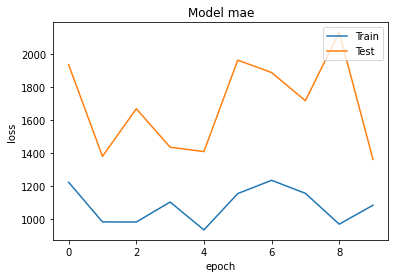

In [122]:
plot(history.history['mae'], history.history['val_mae'], 'Model mae')

###### Plot Loss

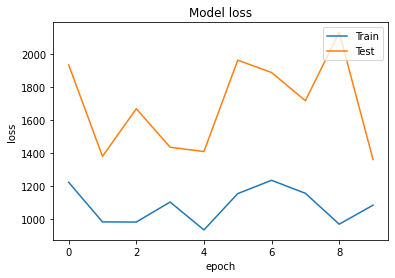

In [123]:
plot(history.history['loss'], history.history['val_loss'], 'Model loss')